In [15]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import datetime as dt
pd.set_option('display.max_rows', None)

# Plotting both phase-normalized Normal EW and EW STD versus time
# Like widths script, currently using 3-region version (same EWs in CSV with widths as without, though)

In [16]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs, print_outliers=True):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
    
    if print_outliers:
        print('Removed outlier OBSIDs:', outlier_obs)
        print('Unique observation names:', len(obsdata))
        print()
    return obsdata

def color_outliers(obsdata, outlier_obs):
    #returns df with only the outlier obsids
    #then can plot these in a different color on EW plots
    outlier_obsdata = obsdata.loc[outlier_obs]
    
    return outlier_obsdata

In [17]:
# Define plotting functions (pass in hg_used_data or other similar dataframe) 

def trendline(obsdata, x_col, y_col, deg, time_data=False):
    #returns x, y data for trendline for the data vs. time 
    
    
    if time_data:
        #convert dates to floats to be able to use for polyfit (days since first observation)
        obsdata['Time Delta'] = (obsdata[x_col] - obsdata[x_col].min()) \
                                            / np.timedelta64(1,'D')
        x_vals_to_fit = obsdata['Time Delta']
    else:
        x_vals_to_fit = obsdata[x_col]
    
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    coeff = np.polyfit(x_vals_to_fit, obsdata[y_col], deg=deg)
    x_min = x_vals_to_fit.min()
    x_max = x_vals_to_fit.max()
    xrange = np.linspace(x_min, x_max, 100)
    
    if time_data:
        xrange_vals = [obsdata[x_col][0]+ dt.timedelta(days = x_days) for x_days in xrange]
    else:
        xrange_vals = xrange
    
    return xrange_vals, np.polyval(coeff, xrange)

# Plot EW vs. Time
def pn_ew_vs_time(obsdata, outliers, ew_col='Normal EW3ZPN', ew_std_col='Normal EW3ZPN Std', time_col='Date', ylabel='EW (PN, corrected)'):
    
    plt.figure()
    plt.scatter(obsdata[time_col], obsdata[ew_col], c='purple', alpha=0.7, label='regular observations')
    plt.scatter(outliers[time_col], outliers[ew_col], c='lightcoral', edgecolors='black', label='phase curve outliers') #c='purple', edgecolors='black')
    #plot a trendline
    (x_trend, y_trend) = trendline(obsdata, time_col, ew_col, deg=3, time_data=True)
    plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Time')
    plt.legend()
    plt.show()  
    
    #also do Std. vs. time (since now done automatically in calculations)
    plt.figure()
    plt.scatter(obsdata[time_col], obsdata[ew_std_col], c='mediumorchid', alpha=0.7, label='regular observations')
    plt.scatter(outliers[time_col], outliers[ew_std_col], c='lightcoral', edgecolors='black', label='phase curve outliers') #c='mediumorchid', edgecolors='black')
    #plot a trendline
    (x_trend, y_trend) = trendline(obsdata, time_col, ew_std_col, deg=3, time_data=True)
    plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Date')
    plt.ylabel(ylabel+' Std.')
    plt.title(ylabel+ ' Std. vs. Time')
    plt.legend()
    plt.show()
    

    
# Plot EW vs. Prometheus Distance
def pn_ew_vs_p_dist(obsdata, outliers, dist_filepath, ew_col='Normal EW3ZPN', ylabel='EW (PN, corrected)'):
    
    #read in the datafile with widths for Prometheus
    prometheus_dist = pd.read_csv(dist_filepath, parse_dates=['Date'], index_col='Observation')
    outliers_p_dist = prometheus_dist.copy()

    #remove all obsids in the Prometheus distance data that aren't in the hg_used_data data
    to_remove = []
    to_remove_outliers = []
    for obsid in prometheus_dist.index:
        if obsid not in obsdata.index:
            to_remove.append(obsid)
    prometheus_dist = remove_outliers(prometheus_dist, to_remove)
    
    for obsid in outliers_p_dist.index:
        if obsid not in outliers.index:
            to_remove_outliers.append(obsid)
    outliers_p_dist = remove_outliers(outliers_p_dist, to_remove_outliers, print_outliers=False)

    plt.figure()
    plt.scatter(prometheus_dist['Prometheus Min Dist'], obsdata[ew_col], c='mediumseagreen', alpha=0.7)
    plt.scatter(outliers_p_dist['Prometheus Min Dist'], outliers[ew_col], c='lightcoral', edgecolors='black')# c='mediumseagreen', edgecolors='black')
    
    #plot a trendline
    x_vals_to_fit = prometheus_dist['Prometheus Min Dist']
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    coeff = np.polyfit(x_vals_to_fit, obsdata[ew_col], deg=3)
    x_min = x_vals_to_fit.min()
    x_max = x_vals_to_fit.max()
    xrange = np.linspace(x_min, x_max, 100)
    x_trend = xrange
    y_trend = np.polyval(coeff, xrange)
    plt.plot(x_trend, y_trend, '-', color='black')
    
    plt.xlabel('Min Dist. from Prometheus (km)')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Min. Distance\nfrom Prometheus')
    plt.show()
    
    

# Plot EW vs. Mu, Mu0, Phase Angle (should have understandable/no dependence)
def pn_ew_vs_viewing_angles(obsdata, outliers, ew_col='Normal EW3ZPN', mu_col='Mu', mu0_col='Mu0', phase_col='Mean Phase', ylabel='EW (PN, corrected)'):
    
    plt.figure()
    plt.scatter(obsdata[mu_col], obsdata[ew_col], c='coral', alpha=0.7)
    plt.scatter(outliers[mu_col], outliers[ew_col], c='lightcoral', edgecolors='black')#  c='coral',edgecolors='black')
    #trendline
    (x_trend, y_trend) = trendline(obsdata, mu_col, ew_col, deg=3)
    plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Mu (cos(emission angle))')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Mu')
    plt.show()
    
    plt.figure()
    plt.scatter(obsdata[mu0_col], obsdata[ew_col], c='deepskyblue', alpha=0.7)
    plt.scatter(outliers[mu0_col], outliers[ew_col], c='lightcoral', edgecolors='black')# c='deepskyblue', edgecolors='black')
    #trendline
    (x_trend, y_trend) = trendline(obsdata, mu0_col, ew_col, deg=3)
    plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Mu0 (cos(incidence angle))')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Mu0')
    plt.show()
    
    plt.figure()
    plt.scatter(obsdata[phase_col], obsdata[ew_col], c='midnightblue', alpha=0.7)
    plt.scatter(outliers[phase_col], outliers[ew_col],c='lightcoral', edgecolors='black')#  , c='midnightblue', edgecolors='black')
    #trendline
    (x_trend, y_trend) = trendline(obsdata, phase_col, ew_col, deg=3)
    plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Phase angle')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Phase angle')
    plt.show()

def phase_curve(obsdata, outliers, ew_col='Normal EW3Z', ylabel='Normal EW'):
    
    plt.figure()
    plt.scatter(obsdata['Mean Phase'], obsdata[ew_col], c='blue', alpha=0.7)
    plt.scatter(outliers['Mean Phase'], outliers[ew_col], c='lightcoral', edgecolors='black')# c='blue', edgecolors='black')
    plt.xlabel('Phase Angle')
    plt.ylabel(ylabel)
    plt.title(ylabel+' vs. Phase Angle')
    plt.show()
    
    
def pn_ew_fit_curve(obsdata, outliers, deg=3, ew_col='Normal EW3ZPN', ew_std_col='Normal EW3ZPN Std', \
                    time_col='Date', joint_moon_data=None):
        
    #read in the datafile with widths for Prometheus
    prometheus_dist = pd.read_csv(dist_filepath, parse_dates=['Date'], index_col='Observation')
    outliers_p_dist = prometheus_dist.copy()
    #remove all obsids in the Prometheus distance data that aren't in the hg_used_data data
    to_remove = []
    to_remove_outliers = []
    for obsid in prometheus_dist.index:
        if obsid not in obsdata.index:
            to_remove.append(obsid)
    prometheus_dist = remove_outliers(prometheus_dist, to_remove)
    for obsid in outliers_p_dist.index:
        if obsid not in outliers.index:
            to_remove_outliers.append(obsid)
    outliers_p_dist = remove_outliers(outliers_p_dist, to_remove_outliers, print_outliers=False)
    
                    
    #convert dates to floats to be able to use for polyfit (days since first observation)
    #obsdata['Time Delta'] = (obsdata[time_col] - obsdata[time_col].min()) \
    #                                       / np.timedelta64(1,'D')
    
    #plot the data
    fig, ax1 = plt.subplots()   
    #plot 1: EW vs. Time (incl. outliers, best-fit curve)
    ax1.set_xlabel('Time') 
    ax1.set_ylabel('Equivalent Width', color = 'purple') 
    ax1.scatter(obsdata[time_col], obsdata[ew_col], c='purple', alpha=0.7)
    #ax1.scatter(outliers[time_col], outliers[ew_col], c='hotpink', edgecolors='gray') 
    
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    (x_trend, y_trend) = trendline(obsdata, time_col, ew_col, deg, time_data=True)
    ax1.plot(x_trend, y_trend, '-', color='black')
    ax1.tick_params(axis ='y', labelcolor = 'purple') 

    # Adding Twin Axes
    ax2 = ax1.twinx() 

    ax2.set_ylabel('Min. Dist from Prometheus', color = 'mediumseagreen') 
    ax2.scatter(prometheus_dist['Date'], prometheus_dist['Prometheus Min Dist'], c='mediumseagreen', alpha=0.7)
    #ax2.scatter(outliers_p_dist['Date'], outliers_p_dist['Prometheus Min Dist'], c='gold', edgecolors='black')
    ax2.tick_params(axis ='y', labelcolor = 'mediumseagreen') 
    ax2.invert_yaxis()
    
    plt.title(f'EW and Prometheus Dist. vs. Time (deg={deg})')

    # Show plot
    plt.show()
    

def pn_ew_moon_curve(obsdata, outliers, deg=3, ew_col='Normal EW3ZPN', ew_std_col='Normal EW3ZPN Std', \
                    time_col='Date', joint_moon_data=None):
        
    #read in the datafile with widths for Prometheus
    prometheus_dist = pd.read_csv(dist_filepath, parse_dates=['Date'], index_col='Observation')
    outliers_p_dist = prometheus_dist.copy()
    #also read in the datafile with widths for Pandora
    
    #remove all obsids in the Prometheus distance data that aren't in the hg_used_data data
    to_remove = []
    to_remove_outliers = []
    for obsid in prometheus_dist.index:
        if obsid not in obsdata.index:
            to_remove.append(obsid)
    prometheus_dist = remove_outliers(prometheus_dist, to_remove)
    for obsid in outliers_p_dist.index:
        if obsid not in outliers.index:
            to_remove_outliers.append(obsid)
    outliers_p_dist = remove_outliers(outliers_p_dist, to_remove_outliers, print_outliers=False)
    
                    
    #convert dates to floats to be able to use for polyfit (days since first observation)
    #obsdata['Time Delta'] = (obsdata[time_col] - obsdata[time_col].min()) \
    #                                       / np.timedelta64(1,'D')
    
    #plot the data
    fig, ax1 = plt.subplots()   
    #plot 1: EW vs. Time (incl. outliers, best-fit curve)
    ax1.set_xlabel('Time') 
    ax1.set_ylabel('Equivalent Width', color = 'purple') 
    ax1.scatter(obsdata[time_col], obsdata[ew_col], c='purple', alpha=0.7)
    #ax1.scatter(outliers[time_col], outliers[ew_col], c='hotpink', edgecolors='gray') 
    
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    (x_trend, y_trend) = trendline(obsdata, time_col, ew_col, deg, time_data=True)
    ax1.plot(x_trend, y_trend, '-', color='black')
    ax1.tick_params(axis ='y', labelcolor = 'purple') 

    # Adding Twin Axes
    ax2 = ax1.twinx() 

    ax2.set_ylabel('Min. Dist from Prometheus', color = 'mediumseagreen') 
    ax2.scatter(prometheus_dist['Date'], prometheus_dist['Prometheus Min Dist'], c='mediumseagreen', alpha=0.7)
    #ax2.scatter(outliers_p_dist['Date'], outliers_p_dist['Prometheus Min Dist'], c='gold', edgecolors='black')
    ax2.tick_params(axis ='y', labelcolor = 'mediumseagreen') 
    ax2.invert_yaxis()
    
    plt.title(f'EW and Prometheus Dist. vs. Time (deg={deg})')

    # Show plot
    plt.show()

In [18]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

# path to Prometheus distance file
dist_filepath = '/Users/mlessard/REU_2022/data/prometheus_dist.csv'

#using the CSV data created with 3 regions or not?
three_region = True

#radii values (three-region)
radii = [139470, 140170, 140265, 140965]

# slice/step size of the csv file, currently only have 0
size = 0

# degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#remove outliers? (not including EQX values)
rm_outliers = True

#nstd to remove for HG param tau fitting
nstd = None

# list outlier obsids
outliers = []
outliers = outliers + ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME'] #~50-60 outliers
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers

ms=20
alpha=0.7

In [19]:
# Read in the CSV file

#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [20]:
#print initial statistics
print('** ORIGINAL SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)

** ORIGINAL SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/ew_stats_widths_139470_140170_140265_140965_0.csv


In [21]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#get df with just outliers to plot in different color
outlier_obsdata = color_outliers(removed_eqx_obsdata, outliers)

#remove outliers
if rm_outliers:
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)
else:
    obsdata = removed_eqx_obsdata

#print final statistics
print('** FINAL SUMMARY STATISTICS **')
print('Unique observation names:', len(obsdata.groupby('Observation')))
print('Total slices:', len(obsdata))
print('Starting date:', obsdata['Date'].min())
print('Ending date:', obsdata['Date'].max())
print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
print()

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS']
Unique observation names: 136

** FINAL SUMMARY STATISTICS **
Unique observation names: 136
Total slices: 136
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39



In [22]:
print(obsdata.columns)

Index(['Slice#', 'Num Data', 'Date', 'Min Long', 'Max Long', 'Mean Long',
       'Min Inertial Long', 'Max Inertial Long', 'Mean Inertial Long',
       'Min Long of Pericenter', 'Max Long of Pericenter',
       'Mean Long of Pericenter', 'Min True Anomaly', 'Max True Anomaly',
       'Mean True Anomaly', 'Min Res', 'Max Res', 'Mean Res', 'Min Phase',
       'Max Phase', 'Mean Phase', 'Min Emission', 'Max Emission',
       'Mean Emission', 'Incidence', '% Coverage', 'EW', 'EW Std', 'Normal EW',
       'Normal EW Std', 'EWI', 'EWI Std', 'Normal EWI', 'Normal EWI Std',
       'EWC', 'EWC Std', 'Normal EWC', 'Normal EWC Std', 'EWO', 'EWO Std',
       'Normal EWO', 'Normal EWO Std', 'Normal EW3Z', 'Normal EW3Z Std',
       'Normal EW3ZPN', 'Normal EW3ZPN Std', 'Width1', 'Width1 Std', 'Width2',
       'Width2 Std', 'Width3', 'Width3 Std', 'Width1I', 'Width1I Std',
       'Width1O', 'Width1O Std', 'Width2I', 'Width2I Std', 'Width2O',
       'Width2O Std', 'Width3I', 'Width3I Std', 'Width3O', 

136
136


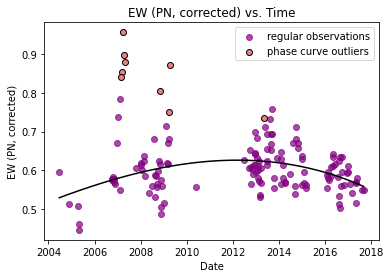

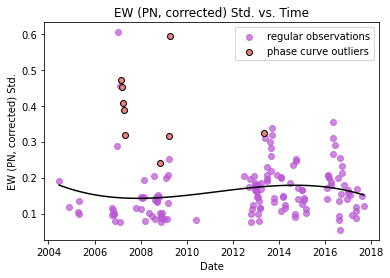

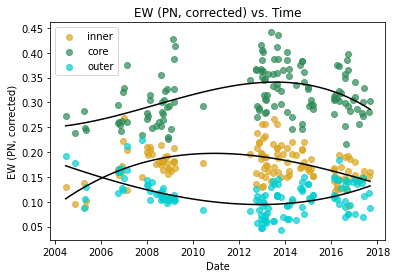

In [23]:
print(len(obsdata['Normal EWI']))
print(len(obsdata['Mean Phase']))

# plot PN EW vs. time (also do Std.)
pn_ew_vs_time(obsdata, outlier_obsdata)

# oh make a plot of the core/inner/outer EW vs. time separately
time_col = 'Date'

#tau-correct + phase-normalize these values
obsdata['C Normal EWI'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None))
obsdata['C Normal EWC'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWC', 0.042))
obsdata['C Normal EWO'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWO', None))


phases = obsdata['Mean Phase']
hg_params = [0.63398345, 1.87442474, -0.02580002, 0.87617994]
hg_phase_model = hg_func(hg_params, phases)
hg_zeros_value = hg_func(hg_params, 0) #value of HG function for phase angle of 0 (phase(0))

#phase-normalize each of the tau-corrected zones
obsdata['PN C Normal EWI'] = obsdata['C Normal EWI']/(hg_phase_model/hg_zeros_value)
obsdata['PN C Normal EWC'] = obsdata['C Normal EWC']/(hg_phase_model/hg_zeros_value)
obsdata['PN C Normal EWO'] = obsdata['C Normal EWO']/(hg_phase_model/hg_zeros_value)

#plot the scatter points for each of the 3 zones + trendlines
plt.figure()
plt.scatter(obsdata[time_col], obsdata['PN C Normal EWI'], c='goldenrod', alpha=0.7, label='inner')
(x_trend_i, y_trend_i) = trendline(obsdata, time_col, 'PN C Normal EWI', time_data=True, deg=3)
plt.plot(x_trend_i, y_trend_i, '-', color='black')

plt.scatter(obsdata[time_col], obsdata['PN C Normal EWC'], c='seagreen', alpha=0.7, label='core')
(x_trend_c, y_trend_c) = trendline(obsdata, time_col, 'PN C Normal EWC', time_data=True, deg=3)
plt.plot(x_trend_c, y_trend_c, '-', color='black')

plt.scatter(obsdata[time_col], obsdata['PN C Normal EWO'], c='darkturquoise', alpha=0.7, label='outer')
(x_trend_o, y_trend_o) = trendline(obsdata, time_col, 'PN C Normal EWO', time_data=True, deg=3)
plt.plot(x_trend_o, y_trend_o, '-', color='black')

#plot the trendline for the inner+outer data combined
obsdata['PN C Normal EWIO'] = obsdata['PN C Normal EWI'] + obsdata['PN C Normal EWO']
(x_trend_io, y_trend_io) = trendline(obsdata, time_col, 'PN C Normal EWIO', time_data=True, deg=3)
#plt.plot(x_trend_io, y_trend_io, '-', color='maroon')
#plt.plot(x_trend_io, y_trend_io/2, '-', color='maroon', label='combined skirt\ntrendline')

plt.xlabel('Date')
plt.ylabel('EW (PN, corrected)')
plt.title('EW (PN, corrected) vs. Time')
plt.legend()
plt.show()


Removed outlier OBSIDs: ['ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS', 'ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 136



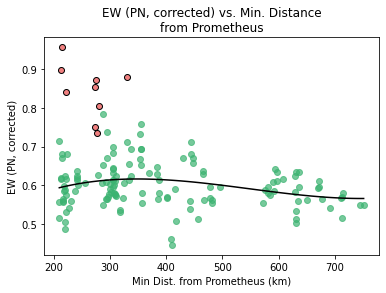

In [24]:
# plot PN EW vs. min. distance of Prometheus
pn_ew_vs_p_dist(obsdata, outlier_obsdata, dist_filepath)

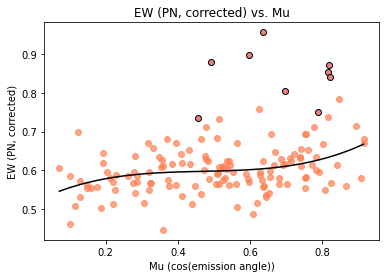

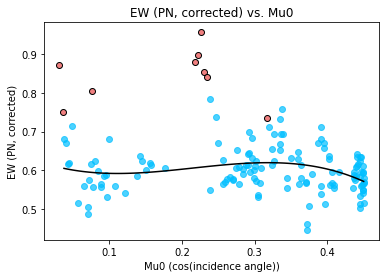

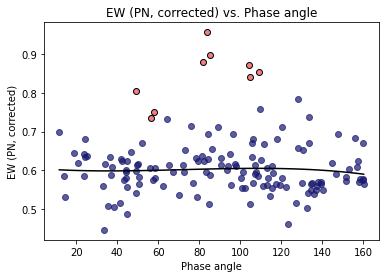

In [25]:
# plot PN EW vs. Mu / Mu0 / Phase angle
pn_ew_vs_viewing_angles(obsdata, outlier_obsdata)

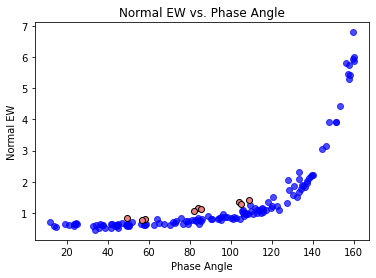

In [26]:
# plot the regular phase curve, just to have it
phase_curve(obsdata, outlier_obsdata)

Removed outlier OBSIDs: ['ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS', 'ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 136



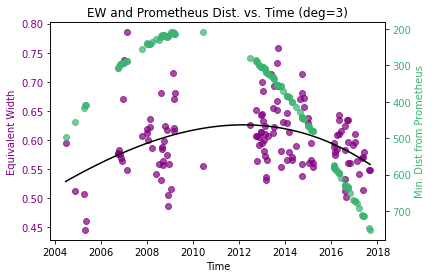

Removed outlier OBSIDs: ['ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS', 'ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 136



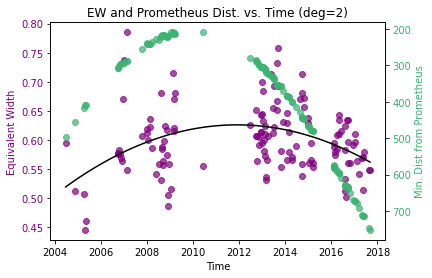

In [27]:
# plot EW vs. time (removing outliers), fitting a curve (quadratic or cubic) to the data
# also plot Prometheus dist. on a second y-axis 
pn_ew_fit_curve(obsdata, outlier_obsdata)
pn_ew_fit_curve(obsdata, outlier_obsdata, deg=2)

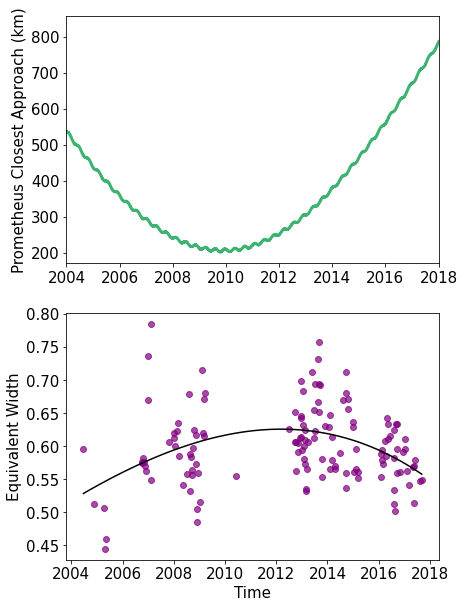

In [30]:
# plot the distances from both Prometheus and Pandora on top of this as well
data_dir = '/Users/mlessard/REU_2022/data/'

prometheus_data = pd.read_csv(data_dir+'prometheus_historical.csv', parse_dates=['Date'], index_col='Date')
pandora_data = pd.read_csv(data_dir+'pandora_historical.csv', parse_dates=['Date'], index_col='Date')
joint_data = prometheus_data.join(pandora_data, on='Date', how='inner')
joint_data.index = pd.to_datetime([x[:10] for x in joint_data.index])


# plot a 2-section plot with moons distances vs. time on top, EWs w/o outliers on bottom

# plot the moon data
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(6.67,10))

ax = []

#create upper subplot + plot Prometheus moon data
ax.append(plt.subplot(211))
plt.plot(joint_data.index, joint_data['Prometheus Distance'], '-', color='mediumseagreen', lw=3)
#plt.yticks(color='mediumseagreen')
plt.ylabel('Prometheus Closest Approach (km)') #, c='mediumseagreen')

#create plot on secondary y-axis of upper subplot (plot Pandora moon data)
#ax.append(ax[0].twinx())
#plt.plot(joint_data.index, joint_data['Pandora Distance'], '-', color='mediumorchid')
#plt.yticks(color='mediumorchid')
#plt.ylabel('Pandora Closest Approach (km)', c='mediumorchid')
#plt.title(f'EW and Prometheus Dist. vs. Time')
plt.xlim([dt.date(2004, 1, 1), dt.date(2018, 1, 1)])

#create lower subplot (plot EW data)
time_col = 'Date'
ew_col= 'Normal EW3ZPN'
deg=3
#convert dates to time delta to be able to plot trendline
obsdata['Time Delta'] = (obsdata[time_col] - obsdata[time_col].min()) \
                                     / np.timedelta64(1,'D')

ax.append(plt.subplot(212))
plt.scatter(obsdata[time_col], obsdata[ew_col], c='purple', alpha=0.7)
(x_trend, y_trend) = trendline(obsdata, time_col, ew_col, deg, time_data=True)
plt.plot(x_trend, y_trend, '-', color='black')

plt.xlabel('Time')
plt.ylabel('Equivalent Width')

plt.show()

